In [1]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

C:\ProgramData\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\ProgramData\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

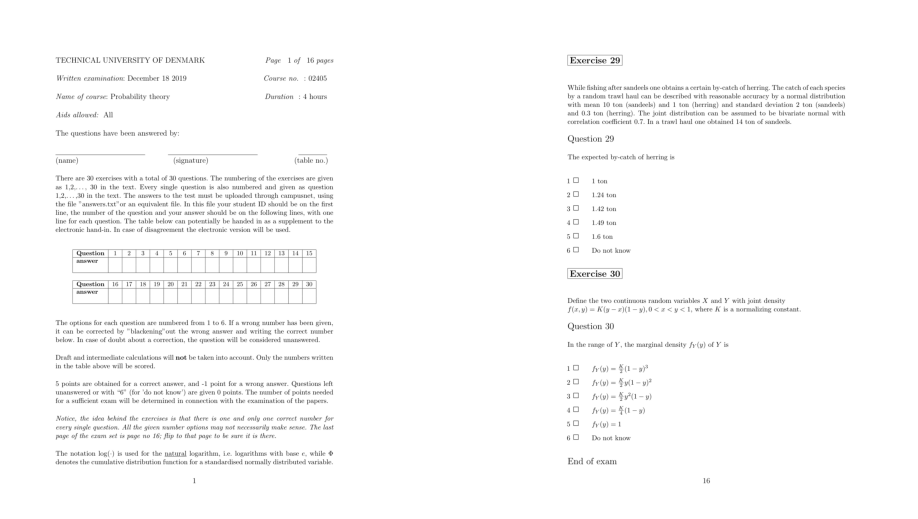

In [3]:
from pathlib import Path
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

pdf_path = "02405_Dec2019.pdf" 
pdf = fitz.open(pdf_path)

images = []
for i in range(pdf.page_count):
    pix = pdf[i].get_pixmap(dpi=144)
    img_bytes = pix.tobytes("png")
    image = Image.open(io.BytesIO(img_bytes))
    images.append(image)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(images[0])
ax1.axis('off')

ax2.imshow(images[-1])
ax2.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0, left=0, right=1, top=1, bottom=0)
plt.show()


In [4]:
from tqdm import tqdm

all_text = ""

for page_image in tqdm(images):
    pixel_values = processor(images=page_image, return_tensors="pt").pixel_values.to(device)
    outputs = model.generate(
        pixel_values,
        min_length=1,
        max_length=4096,
        eos_token_id=processor.tokenizer.eos_token_id,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True,
    )
    text = processor.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    all_text += text + "\n\n"
print('\n'.join(all_text.splitlines()[:50]))

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [05:10<00:00, 19.40s/it]

_Written examination_: December 18 2019 _Name of course_: Probability theory _Aids allowed:_ All

The questions have been answered by:

\begin{tabular}{}

\end{tabular}

There are 30 exercises with a total of 30 questions. The numbering of the exercises are given as 1,2,..., 30 in the text. Every single question is also numbered and given as question 1,2,...,30 in the text. The answers to the test must be uploaded through campusnet, using the file "answers.txt"or an equivalent file. In this file your student ID should be on the first line, the number of the question and your answer should be on the following lines, with one line for each question. The table below can potentially be handed in as a supplement to the electronic hand-in. In case of disagreement the electronic version will be used.

\begin{tabular}{}

\end{tabular}

The options for each question are numbered from 1 to 6. If a wrong number has been given, it can be corrected by "blackening"out the wrong answer and writing th

*Observed that Nougat sometimes ignores the first exercise title on certain pages, and the recognized answer options appear in many different formats.

In [5]:
import re

raw_text = all_text

patterns = [
    r"\\\[\\begin\{(?:array|tabular)\}(?:\[\]\{[^\}]*\})?",
    r"\\begin\{(?:array|tabular)\}(?:\[\]\{[^\}]*\})?",
    r"\\end\{(?:array|tabular)\}\\\]",
    r"\\end\{(?:array|tabular)\}",
    r"\\\]",
    r"\\\["
]

for pat in patterns:
    raw_text = re.sub(pat, "", raw_text)
    
raw_text = re.sub(r'\\\\\s*(?=\d+\\\s*\\square)', '\n', raw_text)

In [7]:
import re
import json
lines = raw_text.splitlines()
questions = []
i = 0
while i < len(lines):
   line = lines[i].strip()
   qn_match = re.match(r"Question\s*(\d+)", line)
   if qn_match:
       question_id = qn_match.group(1)
       # find previous non-empty line as context
       j = i - 1
       while j >= 0 and lines[j].strip() == "":
           j -= 1
       context = lines[j].strip() if j >= 0 else ""
       # find next non-empty line as question
       k = i + 1
       while k < len(lines) and lines[k].strip() == "":
           k += 1
       raw_question = lines[k].strip() if k < len(lines) else ""
       # Check if it starts with a number
       if re.match(r"^(\(?\d+\)?|\\\(\d+)", raw_question):
           question = ""
           l = k   # start collecting options directly from this line
       else:
           question = raw_question
           l = k + 1  # start collecting options from next line normally
       # collect the next 6 non-empty lines as options, only those starting with numbers
       options = []
       count = 0
       while l < len(lines) and count < 6:
           opt_line = lines[l].strip()
           # only collect lines starting with numbers
           if re.match(r"^(\(?\d+\)?|\\\(\d+)", opt_line):
               options.append(opt_line)
               count += 1
           l += 1
       questions.append({
           "question_id": question_id,
           "context": context,
           "question": question,
           "options": options
       })
       i = l
       continue
   i += 1

print(questions[0])
with open('questions.json', 'w', encoding='utf-8') as f:
   json.dump(questions, f, indent=2, ensure_ascii=False)

print(f"Successfully saved {len(questions)} questions to questions.json")

{'question_id': '1', 'context': 'A specific geographical area has a population of 1 million, 5% belong to a certain ethnic group. A group of 100 people is selected at random for a survey.', 'question': 'The probability that there are at least 7 persons from the ethnic group in the sample is', 'options': ['\\(1\\)\\(\\square\\)\\(1-\\Phi\\left(\\frac{2}{\\sqrt{19}}\\right)\\)', '\\(2\\)\\(\\square\\)\\(1-\\Phi\\left(\\frac{3}{\\sqrt{18}}\\right)\\)', '\\(3\\)\\(\\square\\)\\(\\frac{1}{12}\\)', '\\(4\\)\\(\\square\\)\\(1-\\sum_{i=0}^{6}{100\\choose i}(0.05)^{i}(1-0.05)^{100-i}\\)', '\\(5\\)\\(\\square\\)\\(1-\\sum_{i=0}^{6}\\frac{e^{-5}5^{i}}{i!}\\)', '\\(6\\)\\(\\square\\) Do not know']}
Successfully saved 30 questions to questions.json
